In [1]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
import pandas as pd

DataPath = './Dataset/VietNamWeather.csv'
Dataframe = pd.read_csv(DataPath).reset_index(drop=True)

Dataframe.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181960 entries, 0 to 181959
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   province  181960 non-null  object 
 1   max       181960 non-null  int64  
 2   min       181960 non-null  int64  
 3   wind      181960 non-null  int64  
 4   wind_d    181960 non-null  object 
 5   rain      181960 non-null  float64
 6   humidi    181960 non-null  int64  
 7   cloud     181960 non-null  int64  
 8   pressure  181960 non-null  int64  
 9   date      181960 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 13.9+ MB


In [3]:
Dataframe['temp'] = (Dataframe['max'] + Dataframe['min']) / 2
NewDf = Dataframe[['temp', 'wind', 'humidi', 'cloud', 'pressure']]

RainThreshold = 1.8
NewDf['israin'] = (Dataframe['rain'] > RainThreshold).astype(int)

NewDf['wind'] *= 0.277777778 # km/h to m/s

NewDf.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181960 entries, 0 to 181959
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   temp      181960 non-null  float64
 1   wind      181960 non-null  float64
 2   humidi    181960 non-null  int64  
 3   cloud     181960 non-null  int64  
 4   pressure  181960 non-null  int64  
 5   israin    181960 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 8.3 MB


In [4]:
NewDf.head(10)

,temp,wind,humidi,cloud,pressure,israin
0,24.5,4.722222,90,71,1010,1
1,28.0,5.555556,64,24,1010,0
2,26.5,3.888889,75,45,1008,0
3,27.0,8.333333,79,52,1012,0
4,28.0,5.555556,70,24,1010,0
5,25.5,3.888889,75,55,1012,0
6,26.0,2.777778,75,42,1012,0
7,28.0,6.111111,63,9,1015,0
8,27.0,5.555556,76,35,1011,0
9,26.0,4.444444,70,33,1010,0


In [5]:
import numpy as np

Data = NewDf.drop(columns='israin').values
Target = NewDf['israin'].values

np.save('./Data.npy', Data)
np.save('./Target.npy', Target)

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('Standard scaling', StandardScaler()),
     ('Normalize', Normalizer())]).fit(X=Data, y=Target)

Data = pipeline.transform(X=Data)
Target = LabelEncoder().fit_transform(Target)

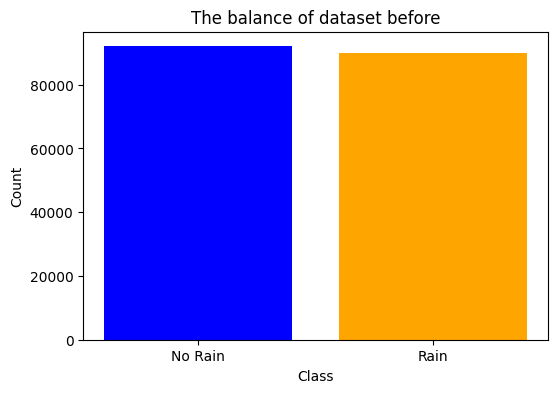

In [7]:
import matplotlib.pyplot as plt
import numpy as np

unique_values, counts = np.unique(Target, return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(unique_values, counts, color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('The balance of dataset before')
plt.xticks(unique_values, ['No Rain', 'Rain'])
plt.show()

In [8]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data, label):
      super().__init__()
      self.train = data
      self.label = label

    def __len__(self):
      return self.train.shape[0]

    def __getitem__(self, index: int):
        return self.train[index], self.label[index]

X_train, X_test, Y_train, Y_test = train_test_split(Data, Target, test_size=0.2)

# Convert data to PyTorch tensors and move to GPU
TrainData = torch.tensor(X_train, dtype=torch.float32, device=device)
TrainLabel = torch.tensor(Y_train, dtype=torch.long, device=device)

ValidData = torch.tensor(X_test, dtype=torch.float32, device=device)
ValidLabel = torch.tensor(Y_test, dtype=torch.long, device=device)

# Create dataloader
TrainDataset = CustomDataset(TrainData, TrainLabel)
ValidDataset = CustomDataset(ValidData, ValidLabel)

TrainDataloader = DataLoader(TrainDataset, batch_size=64, shuffle=True, num_workers=4)
ValidDataloader = DataLoader(ValidDataset, batch_size=64, shuffle=True, num_workers=4)

In [10]:
import torch

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.report = None
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.best_acc = None
        self.early_stop = False

    def __call__(self, model, val_loss, val_acc, report):


        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.report = report
            ExportPATH = f'./ModelCheckpoint/SoftOrdering1DCNN.pth'
            torch.save(model.state_dict(), ExportPATH)

        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best loss: {self.best_loss}')
            print(f'Best accuracy: {self.best_acc}')

            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.report = report
            self.counter = 0
            ExportPATH = f'./ModelCheckpoint/SoftOrdering1DCNN.pth'
            torch.save(model.state_dict(), ExportPATH)

In [11]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

def TrainModel(model, loss_fn, optimizer, train_loader, scheduler=None, schd_batch_update=False):
        model.train()
        running_loss = None

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for step, (data, label) in pbar:
            scaler = GradScaler()
            with autocast():
                output = model(data)
                loss = loss_fn(output, label)
                scaler.scale(loss).backward()

                if running_loss is None:
                    running_loss = loss.item()
                else:
                    running_loss = running_loss * .99 + loss.item() * .01

                if ((step + 1) %  2 == 0) or ((step + 1) == len(train_loader)):
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                    if scheduler is not None and schd_batch_update:
                        scheduler.step()

                if ((step + 1) % 2 == 0) or ((step + 1) == len(train_loader)):
                    description = f'Loss: {running_loss:.4f}'

                    pbar.set_description(description)

        if scheduler is not None and not schd_batch_update:
           scheduler.step()

def EvalModel(model, loss_fn, val_loader, early_stopping=None, scheduler=None, schd_loss_update=False):
        model.eval()

        loss_sum = 0
        sample_num = 0
        preds_all = []
        targets_all = []

        pbar = tqdm(enumerate(val_loader), total=len(val_loader))
        for step, (data, label) in pbar:
            predict = model(data)
            preds_all += [torch.argmax(predict, 1).detach().cpu().numpy()]
            targets_all += [label.detach().cpu().numpy()]

            loss = loss_fn(predict, label)

            loss_sum += loss.item() * label.shape[0]
            sample_num += label.shape[0]

            if ((step + 1) % 2 == 0) or ((step + 1) == len(val_loader)):
                description = f'Loss: {loss_sum/sample_num:.4f}'
                pbar.set_description(description)

        preds_all = np.concatenate(preds_all)
        targets_all = np.concatenate(targets_all)

        report = classification_report(targets_all, preds_all, digits=4)
        print("Classification report")
        print(report)
        print("F1 micro averaging:",(f1_score(targets_all, preds_all, average='micro')))

        ValidLoss = loss_sum/sample_num
        ValidAcc = (preds_all==targets_all).mean()

        print('Validation loss', ValidLoss)
        print('Validation accuracy', ValidAcc)
        if early_stopping != None:
          early_stopping(model, ValidLoss, ValidAcc, report)

        if scheduler is not None:
            if schd_loss_update:
                scheduler.step(loss_sum/sample_num)
            else:
                scheduler.step()

In [12]:
from SoftOrdering1DCNN import SoftOrdering1DCNN
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch import nn
torch.backends.cudnn.benchmark = True

input_dim = TrainData.shape[1]
numclass = len(np.unique(TrainLabel.cpu()))
print(f'Feature: {input_dim}')
print(f'Classes: {numclass}')

print('Start building Model...')
model = SoftOrdering1DCNN(input_dim, numclass)
model.to(device)
print('Build Model successfully!')

from adabelief_pytorch import AdaBelief
optimizer = AdaBelief(model.parameters(),
                      lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decay=1e-4,
                      weight_decouple=False, rectify=False, fixed_decay=False, amsgrad=False)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-4, last_epoch=-1)
early_stopping = EarlyStopping(patience=10)

loss_tr = nn.CrossEntropyLoss().to(device)
loss_vl = nn.CrossEntropyLoss().to(device)

epoch = 0
while True:
    epoch += 1
    print('=================================================')
    print(f'\n[ TRAINING EPOCH {epoch} ]')
    TrainModel(model, loss_tr, optimizer, TrainDataloader, scheduler=scheduler, schd_batch_update=True)
    with torch.no_grad():
      print('\n[ EVALUATING VALIDATION ACCURACY ]')
      EvalModel(model, loss_vl, ValidDataloader, early_stopping)
      print('\n-------------------------------------------------\n')
      if early_stopping.early_stop:
            break

Feature: 5
Classes: 2
Start building Model...
Build Model successfully!
Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")



[ TRAINING EPOCH 1 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5418: 100%|██████████| 2275/2275 [00:43<00:00, 52.69it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5309: 100%|██████████| 569/569 [00:04<00:00, 132.21it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7372    0.8461    0.7879     18494
           1     0.8123    0.6884    0.7452     17898

    accuracy                         0.7685     36392
   macro avg     0.7748    0.7672    0.7666     36392
weighted avg     0.7742    0.7685    0.7669     36392

F1 micro averaging: 0.7685205539679051
Validation loss 0.5308855787348711
Validation accuracy 0.7685205539679051

-------------------------------------------------


[ TRAINING EPOCH 2 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5326: 100%|██████████| 2275/2275 [00:41<00:00, 55.38it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5200: 100%|██████████| 569/569 [00:04<00:00, 132.22it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7651    0.8237    0.7933     18494
           1     0.8022    0.7387    0.7691     17898

    accuracy                         0.7819     36392
   macro avg     0.7836    0.7812    0.7812     36392
weighted avg     0.7833    0.7819    0.7814     36392

F1 micro averaging: 0.7819026159595516
Validation loss 0.5200395520950941
Validation accuracy 0.7819026159595516

-------------------------------------------------


[ TRAINING EPOCH 3 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5346: 100%|██████████| 2275/2275 [00:41<00:00, 55.31it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5131: 100%|██████████| 569/569 [00:04<00:00, 134.12it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7943    0.7897    0.7920     18494
           1     0.7840    0.7887    0.7863     17898

    accuracy                         0.7892     36392
   macro avg     0.7891    0.7892    0.7891     36392
weighted avg     0.7892    0.7892    0.7892     36392

F1 micro averaging: 0.7891844361398108
Validation loss 0.5130647326411979
Validation accuracy 0.7891844361398109

-------------------------------------------------


[ TRAINING EPOCH 4 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5313: 100%|██████████| 2275/2275 [00:39<00:00, 57.50it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5129: 100%|██████████| 569/569 [00:04<00:00, 135.31it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7945    0.7900    0.7922     18494
           1     0.7843    0.7888    0.7865     17898

    accuracy                         0.7894     36392
   macro avg     0.7894    0.7894    0.7894     36392
weighted avg     0.7895    0.7894    0.7894     36392

F1 micro averaging: 0.7894317432402725
Validation loss 0.5128988765129338
Validation accuracy 0.7894317432402725

-------------------------------------------------


[ TRAINING EPOCH 5 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5361: 100%|██████████| 2275/2275 [00:39<00:00, 57.37it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5165: 100%|██████████| 569/569 [00:04<00:00, 136.64it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7717    0.8173    0.7939     18494
           1     0.7990    0.7501    0.7738     17898

    accuracy                         0.7843     36392
   macro avg     0.7853    0.7837    0.7838     36392
weighted avg     0.7851    0.7843    0.7840     36392

F1 micro averaging: 0.7842932512640141
Validation loss 0.516484461202284
Validation accuracy 0.7842932512640141
EarlyStopping counter: 1 out of 10
Best loss: 0.5128988765129338
Best accuracy: 0.7894317432402725

-------------------------------------------------


[ TRAINING EPOCH 6 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5346: 100%|██████████| 2275/2275 [00:38<00:00, 59.25it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5128: 100%|██████████| 569/569 [00:04<00:00, 132.63it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7885    0.7997    0.7941     18494
           1     0.7900    0.7784    0.7841     17898

    accuracy                         0.7892     36392
   macro avg     0.7892    0.7890    0.7891     36392
weighted avg     0.7892    0.7892    0.7892     36392

F1 micro averaging: 0.789211914706529
Validation loss 0.5127715751820278
Validation accuracy 0.789211914706529

-------------------------------------------------


[ TRAINING EPOCH 7 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5331: 100%|██████████| 2275/2275 [00:39<00:00, 57.76it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5130: 100%|██████████| 569/569 [00:04<00:00, 134.01it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7908    0.7933    0.7920     18494
           1     0.7857    0.7831    0.7844     17898

    accuracy                         0.7883     36392
   macro avg     0.7882    0.7882    0.7882     36392
weighted avg     0.7883    0.7883    0.7883     36392

F1 micro averaging: 0.7882776434381182
Validation loss 0.5129651199673317
Validation accuracy 0.7882776434381182
EarlyStopping counter: 1 out of 10
Best loss: 0.5127715751820278
Best accuracy: 0.789211914706529

-------------------------------------------------


[ TRAINING EPOCH 8 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5338: 100%|██████████| 2275/2275 [00:39<00:00, 56.98it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5102: 100%|██████████| 569/569 [00:04<00:00, 136.60it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8099    0.7717    0.7903     18494
           1     0.7750    0.8129    0.7935     17898

    accuracy                         0.7919     36392
   macro avg     0.7925    0.7923    0.7919     36392
weighted avg     0.7928    0.7919    0.7919     36392

F1 micro averaging: 0.7919322928116069
Validation loss 0.510195357677936
Validation accuracy 0.7919322928116069

-------------------------------------------------


[ TRAINING EPOCH 9 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5390: 100%|██████████| 2275/2275 [00:40<00:00, 56.69it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5127: 100%|██████████| 569/569 [00:04<00:00, 134.50it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7930    0.7910    0.7920     18494
           1     0.7846    0.7867    0.7856     17898

    accuracy                         0.7889     36392
   macro avg     0.7888    0.7888    0.7888     36392
weighted avg     0.7889    0.7889    0.7889     36392

F1 micro averaging: 0.7888821719059134
Validation loss 0.5127437885160314
Validation accuracy 0.7888821719059134
EarlyStopping counter: 1 out of 10
Best loss: 0.510195357677936
Best accuracy: 0.7919322928116069

-------------------------------------------------


[ TRAINING EPOCH 10 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5343: 100%|██████████| 2275/2275 [00:43<00:00, 51.85it/s]



[ EVALUATING VALIDATION ACCURACY ]


Loss: 0.5117: 100%|██████████| 569/569 [00:04<00:00, 120.95it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8013    0.7827    0.7919     18494
           1     0.7807    0.7995    0.7900     17898

    accuracy                         0.7909     36392
   macro avg     0.7910    0.7911    0.7909     36392
weighted avg     0.7912    0.7909    0.7910     36392

F1 micro averaging: 0.7909430644097604
Validation loss 0.5117027590918944
Validation accuracy 0.7909430644097604
EarlyStopping counter: 2 out of 10
Best loss: 0.510195357677936
Best accuracy: 0.7919322928116069

-------------------------------------------------


[ TRAINING EPOCH 11 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5304: 100%|██████████| 2275/2275 [00:45<00:00, 50.19it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5137: 100%|██████████| 569/569 [00:04<00:00, 120.02it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7925    0.7924    0.7925     18494
           1     0.7855    0.7857    0.7856     17898

    accuracy                         0.7891     36392
   macro avg     0.7890    0.7890    0.7890     36392
weighted avg     0.7891    0.7891    0.7891     36392

F1 micro averaging: 0.7890745218729391
Validation loss 0.5137411445071342
Validation accuracy 0.7890745218729391
EarlyStopping counter: 3 out of 10
Best loss: 0.510195357677936
Best accuracy: 0.7919322928116069

-------------------------------------------------


[ TRAINING EPOCH 12 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5310: 100%|██████████| 2275/2275 [00:44<00:00, 51.40it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5103: 100%|██████████| 569/569 [00:04<00:00, 122.79it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8137    0.7637    0.7879     18494
           1     0.7704    0.8193    0.7941     17898

    accuracy                         0.7911     36392
   macro avg     0.7920    0.7915    0.7910     36392
weighted avg     0.7924    0.7911    0.7910     36392

F1 micro averaging: 0.7910529786766323
Validation loss 0.5102750498283091
Validation accuracy 0.7910529786766323
EarlyStopping counter: 4 out of 10
Best loss: 0.510195357677936
Best accuracy: 0.7919322928116069

-------------------------------------------------


[ TRAINING EPOCH 13 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5296: 100%|██████████| 2275/2275 [00:47<00:00, 47.48it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5099: 100%|██████████| 569/569 [00:05<00:00, 112.63it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8061    0.7764    0.7910     18494
           1     0.7774    0.8070    0.7919     17898

    accuracy                         0.7914     36392
   macro avg     0.7917    0.7917    0.7914     36392
weighted avg     0.7920    0.7914    0.7914     36392

F1 micro averaging: 0.7914376786106837
Validation loss 0.5099451651046972
Validation accuracy 0.7914376786106837

-------------------------------------------------


[ TRAINING EPOCH 14 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5305: 100%|██████████| 2275/2275 [00:47<00:00, 47.84it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5100: 100%|██████████| 569/569 [00:05<00:00, 106.19it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8006    0.7796    0.7899     18494
           1     0.7783    0.7993    0.7886     17898

    accuracy                         0.7893     36392
   macro avg     0.7894    0.7895    0.7893     36392
weighted avg     0.7896    0.7893    0.7893     36392

F1 micro averaging: 0.7892943504066828
Validation loss 0.5099769202293367
Validation accuracy 0.7892943504066828
EarlyStopping counter: 1 out of 10
Best loss: 0.5099451651046972
Best accuracy: 0.7914376786106837

-------------------------------------------------


[ TRAINING EPOCH 15 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5315: 100%|██████████| 2275/2275 [00:50<00:00, 45.03it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5118: 100%|██████████| 569/569 [00:05<00:00, 95.82it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7924    0.7946    0.7935     18494
           1     0.7871    0.7848    0.7860     17898

    accuracy                         0.7898     36392
   macro avg     0.7897    0.7897    0.7897     36392
weighted avg     0.7898    0.7898    0.7898     36392

F1 micro averaging: 0.7897889646076061
Validation loss 0.5118141268132467
Validation accuracy 0.7897889646076061
EarlyStopping counter: 2 out of 10
Best loss: 0.5099451651046972
Best accuracy: 0.7914376786106837

-------------------------------------------------


[ TRAINING EPOCH 16 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5328: 100%|██████████| 2275/2275 [00:50<00:00, 44.86it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5105: 100%|██████████| 569/569 [00:05<00:00, 96.08it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8089    0.7681    0.7880     18494
           1     0.7722    0.8125    0.7919     17898

    accuracy                         0.7900     36392
   macro avg     0.7906    0.7903    0.7899     36392
weighted avg     0.7909    0.7900    0.7899     36392

F1 micro averaging: 0.7899538360079138
Validation loss 0.5105215174453708
Validation accuracy 0.7899538360079138
EarlyStopping counter: 3 out of 10
Best loss: 0.5099451651046972
Best accuracy: 0.7914376786106837

-------------------------------------------------


[ TRAINING EPOCH 17 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5332: 100%|██████████| 2275/2275 [00:50<00:00, 45.39it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5092: 100%|██████████| 569/569 [00:06<00:00, 94.20it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8123    0.7716    0.7914     18494
           1     0.7756    0.8157    0.7952     17898

    accuracy                         0.7933     36392
   macro avg     0.7939    0.7937    0.7933     36392
weighted avg     0.7942    0.7933    0.7933     36392

F1 micro averaging: 0.7933062211475049
Validation loss 0.5091925370454736
Validation accuracy 0.7933062211475049

-------------------------------------------------


[ TRAINING EPOCH 18 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5231: 100%|██████████| 2275/2275 [00:50<00:00, 44.85it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5091: 100%|██████████| 569/569 [00:05<00:00, 102.13it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8061    0.7804    0.7930     18494
           1     0.7803    0.8060    0.7930     17898

    accuracy                         0.7930     36392
   macro avg     0.7932    0.7932    0.7930     36392
weighted avg     0.7934    0.7930    0.7930     36392

F1 micro averaging: 0.7930039569136074
Validation loss 0.5091327533378106
Validation accuracy 0.7930039569136074

-------------------------------------------------


[ TRAINING EPOCH 19 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5377: 100%|██████████| 2275/2275 [00:50<00:00, 45.23it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5104: 100%|██████████| 569/569 [00:05<00:00, 98.17it/s] 


Classification report
              precision    recall  f1-score   support

           0     0.8024    0.7796    0.7908     18494
           1     0.7787    0.8017    0.7900     17898

    accuracy                         0.7904     36392
   macro avg     0.7906    0.7906    0.7904     36392
weighted avg     0.7908    0.7904    0.7904     36392

F1 micro averaging: 0.7904209716421191
Validation loss 0.5103717040926526
Validation accuracy 0.7904209716421191
EarlyStopping counter: 1 out of 10
Best loss: 0.5091327533378106
Best accuracy: 0.7930039569136074

-------------------------------------------------


[ TRAINING EPOCH 20 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5326: 100%|██████████| 2275/2275 [00:50<00:00, 45.26it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5123: 100%|██████████| 569/569 [00:05<00:00, 97.03it/s] 


Classification report
              precision    recall  f1-score   support

           0     0.7901    0.8005    0.7953     18494
           1     0.7910    0.7803    0.7856     17898

    accuracy                         0.7905     36392
   macro avg     0.7905    0.7904    0.7904     36392
weighted avg     0.7905    0.7905    0.7905     36392

F1 micro averaging: 0.790530885908991
Validation loss 0.5123085526220875
Validation accuracy 0.790530885908991
EarlyStopping counter: 2 out of 10
Best loss: 0.5091327533378106
Best accuracy: 0.7930039569136074

-------------------------------------------------


[ TRAINING EPOCH 21 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5330: 100%|██████████| 2275/2275 [00:50<00:00, 44.99it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5104: 100%|██████████| 569/569 [00:05<00:00, 96.38it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7929    0.7922    0.7925     18494
           1     0.7855    0.7862    0.7858     17898

    accuracy                         0.7892     36392
   macro avg     0.7892    0.7892    0.7892     36392
weighted avg     0.7892    0.7892    0.7892     36392

F1 micro averaging: 0.7892393932732469
Validation loss 0.5104283378081784
Validation accuracy 0.7892393932732469
EarlyStopping counter: 3 out of 10
Best loss: 0.5091327533378106
Best accuracy: 0.7930039569136074

-------------------------------------------------


[ TRAINING EPOCH 22 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5258: 100%|██████████| 2275/2275 [00:50<00:00, 45.15it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5125: 100%|██████████| 569/569 [00:05<00:00, 96.80it/s] 


Classification report
              precision    recall  f1-score   support

           0     0.7905    0.7973    0.7939     18494
           1     0.7887    0.7816    0.7851     17898

    accuracy                         0.7896     36392
   macro avg     0.7896    0.7895    0.7895     36392
weighted avg     0.7896    0.7896    0.7896     36392

F1 micro averaging: 0.7895966146405804
Validation loss 0.5124967795894758
Validation accuracy 0.7895966146405804
EarlyStopping counter: 4 out of 10
Best loss: 0.5091327533378106
Best accuracy: 0.7930039569136074

-------------------------------------------------


[ TRAINING EPOCH 23 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5263: 100%|██████████| 2275/2275 [00:47<00:00, 48.08it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5098: 100%|██████████| 569/569 [00:05<00:00, 102.77it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8050    0.7793    0.7919     18494
           1     0.7793    0.8049    0.7919     17898

    accuracy                         0.7919     36392
   macro avg     0.7921    0.7921    0.7919     36392
weighted avg     0.7923    0.7919    0.7919     36392

F1 micro averaging: 0.791904814244889
Validation loss 0.5098273524558787
Validation accuracy 0.791904814244889
EarlyStopping counter: 5 out of 10
Best loss: 0.5091327533378106
Best accuracy: 0.7930039569136074

-------------------------------------------------


[ TRAINING EPOCH 24 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5279: 100%|██████████| 2275/2275 [00:46<00:00, 48.61it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5096: 100%|██████████| 569/569 [00:05<00:00, 105.17it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8030    0.7836    0.7932     18494
           1     0.7818    0.8014    0.7915     17898

    accuracy                         0.7923     36392
   macro avg     0.7924    0.7925    0.7923     36392
weighted avg     0.7926    0.7923    0.7924     36392

F1 micro averaging: 0.7923444713123764
Validation loss 0.5096236722472999
Validation accuracy 0.7923444713123764
EarlyStopping counter: 6 out of 10
Best loss: 0.5091327533378106
Best accuracy: 0.7930039569136074

-------------------------------------------------


[ TRAINING EPOCH 25 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5336: 100%|██████████| 2275/2275 [00:47<00:00, 48.09it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5137: 100%|██████████| 569/569 [00:05<00:00, 105.25it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7804    0.8117    0.7958     18494
           1     0.7970    0.7640    0.7802     17898

    accuracy                         0.7883     36392
   macro avg     0.7887    0.7879    0.7880     36392
weighted avg     0.7886    0.7883    0.7881     36392

F1 micro averaging: 0.7882501648714003
Validation loss 0.5136971420889557
Validation accuracy 0.7882501648714003
EarlyStopping counter: 7 out of 10
Best loss: 0.5091327533378106
Best accuracy: 0.7930039569136074

-------------------------------------------------


[ TRAINING EPOCH 26 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5324: 100%|██████████| 2275/2275 [00:47<00:00, 48.40it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5104: 100%|██████████| 569/569 [00:05<00:00, 106.81it/s]


Classification report
              precision    recall  f1-score   support

           0     0.7979    0.7887    0.7933     18494
           1     0.7843    0.7936    0.7889     17898

    accuracy                         0.7911     36392
   macro avg     0.7911    0.7912    0.7911     36392
weighted avg     0.7912    0.7911    0.7911     36392

F1 micro averaging: 0.7911354143767863
Validation loss 0.5103807349235415
Validation accuracy 0.7911354143767861
EarlyStopping counter: 8 out of 10
Best loss: 0.5091327533378106
Best accuracy: 0.7930039569136074

-------------------------------------------------


[ TRAINING EPOCH 27 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5307: 100%|██████████| 2275/2275 [00:48<00:00, 46.91it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5104: 100%|██████████| 569/569 [00:05<00:00, 109.71it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8083    0.7751    0.7914     18494
           1     0.7771    0.8100    0.7932     17898

    accuracy                         0.7923     36392
   macro avg     0.7927    0.7926    0.7923     36392
weighted avg     0.7929    0.7923    0.7923     36392

F1 micro averaging: 0.7922895141789404
Validation loss 0.5103994501334124
Validation accuracy 0.7922895141789404
EarlyStopping counter: 9 out of 10
Best loss: 0.5091327533378106
Best accuracy: 0.7930039569136074

-------------------------------------------------


[ TRAINING EPOCH 28 ]


  0%|          | 0/2275 [00:00<?, ?it/s]/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/vanlinh/wens/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Loss: 0.5322: 100%|██████████| 2275/2275 [00:47<00:00, 47.43it/s]


[ EVALUATING VALIDATION ACCURACY ]



Loss: 0.5095: 100%|██████████| 569/569 [00:05<00:00, 113.35it/s]


Classification report
              precision    recall  f1-score   support

           0     0.8195    0.7575    0.7873     18494
           1     0.7676    0.8276    0.7965     17898

    accuracy                         0.7920     36392
   macro avg     0.7936    0.7926    0.7919     36392
weighted avg     0.7940    0.7920    0.7918     36392

F1 micro averaging: 0.7920147285117608
Validation loss 0.5095124486043549
Validation accuracy 0.7920147285117608
EarlyStopping counter: 10 out of 10
Best loss: 0.5091327533378106
Best accuracy: 0.7930039569136074

-------------------------------------------------

